In [1]:
import tensorflow as tf
tf.__version__

'2.3.0'

In [2]:
import xml.etree.ElementTree as ET # For parsing XML
from PIL import Image # to read image
import glob
from tqdm import tqdm_notebook
import urllib
import tarfile
import imageio
from imageio import imread, imsave, mimsave
import shutil
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
from tensorflow.keras import layers
import time
from IPython import display
import tensorflow_docs.vis.embed as embed

## 1. Crop images

### Create Datasets

[https://www.kaggle.com/cmalla94/dcgan-generating-dog-images-with-tensorflow#Training-loop](https://www.kaggle.com/cmalla94/dcgan-generating-dog-images-with-tensorflow#Training-loop)

In [3]:
# Code slightly modified from user: cdeotte | https://www.kaggle.com/cdeotte/supervised-generative-dog-net

ROOT = './input/'
# list of all image file names in all-dogs
IMAGES = os.listdir(ROOT + 'all-dogs/all-dogs')
# list of all the annotation directories, each directory is a dog breed
breeds = os.listdir(ROOT + 'annotation/Annotation/') 

idxIn = 0; namesIn = []
imagesIn = np.zeros((25000,64,64,3))

# CROP WITH BOUNDING BOXES TO GET DOGS ONLY
# iterate through each directory in annotation
for breed in breeds:
    # iterate through each file in the directory
    for dog in os.listdir(ROOT+'annotation/Annotation/'+breed):
        try: img = Image.open(ROOT+'all-dogs/all-dogs/'+dog+'.jpg') 
        except: continue           
        # Element Tree library allows for parsing xml and getting specific tag values    
        tree = ET.parse(ROOT+'annotation/Annotation/'+breed+'/'+dog)
        # take a look at the print out of an xml previously to get what is going on
        root = tree.getroot() # <annotation>
        objects = root.findall('object') # <object>
        for o in objects:
            bndbox = o.find('bndbox') # <bndbox>
            xmin = int(bndbox.find('xmin').text) # <xmin>
            ymin = int(bndbox.find('ymin').text) # <ymin>
            xmax = int(bndbox.find('xmax').text) # <xmax>
            ymax = int(bndbox.find('ymax').text) # <ymax>
            w = np.min((xmax - xmin, ymax - ymin))
            img2 = img.crop((xmin, ymin, xmin+w, ymin+w))
            img2 = img2.resize((64,64), Image.ANTIALIAS)
            imagesIn[idxIn,:,:,:] = np.asarray(img2)
            namesIn.append(breed)
            idxIn += 1         

In [4]:
# Inspect what the previous code created
print("imagesIn is a {} with {} {} by {} rgb({}) images. Shape: {}".format(type(imagesIn), imagesIn.shape[0], imagesIn.shape[1], imagesIn.shape[2], imagesIn.shape[3], imagesIn.shape))

imagesIn is a <class 'numpy.ndarray'> with 25000 64 by 64 rgb(3) images. Shape: (25000, 64, 64, 3)


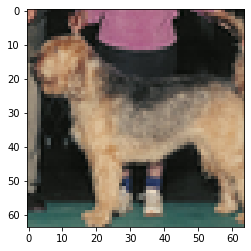

In [5]:
plt.imshow(imagesIn[1].astype(int))

In [6]:
# normalize the pixel values
imagesIn = (imagesIn[:idxIn,:,:,:]-127.5)/127.5 # Normalize the images to [-1, 1]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


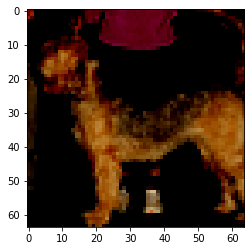

In [7]:
plt.imshow(imagesIn[1])

In [8]:
# this is needed because the gradient functions from TF require float32 instead of float64
imagesIn = tf.cast(imagesIn, 'float32')

In [9]:
def flip(x: tf.Tensor) -> (tf.Tensor):
    x = tf.image.random_flip_left_right(x)
    return x

In [10]:
# Batch and shuffle the data
BUFFER_SIZE = 25000
BATCH_SIZE = 128

train_dataset = tf.data.Dataset.from_tensor_slices(imagesIn).shuffle(BUFFER_SIZE).map(flip).batch(BATCH_SIZE,  drop_remainder=True)
print(train_dataset)

<BatchDataset shapes: (128, 64, 64, 3), types: tf.float32>


## 2. DCGAN

## Greate the models

Both the generator and discriminator are defined using the Keras Sequential API

### The Generator

The generator uses [tf.keras.layers.Conv2DTranspose](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/Conv2DTranspose) (upsampling) layers to produce an image from a seed (random noise). Start with a Dense layer that takes this seed as input, then upsample several times until you reach the desired image size of 64x64x3. Notice the [tf.keras.layers.LeakyReLU](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/LeakyReLU) activation for each layer, except the output layer which uses tanh.


## Hyperparameters

In [11]:
weight_init_std = 0.02
weight_init_mean = 0.0
weight_initializer = tf.keras.initializers.TruncatedNormal(stddev=weight_init_std, mean=weight_init_mean,
                                                          seed=42)
lr_initial_d = tf.Variable(0.0002)
lr_initial_g = tf.Variable(0.0002)
lr_decay_steps = 1000
decay_step = 50
noise_dim = 128
dropout_rate = 0.5

In [12]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*512, use_bias=False, input_shape=(noise_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    
    model.add(layers.Reshape((8, 8, 512)))
    assert model.output_shape == (None, 8, 8, 512)
    model.add(layers.Dropout(dropout_rate))
    
    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(1, 1),  padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Dropout(dropout_rate))
    
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2),  padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2),  padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    
    model.add(layers.Conv2DTranspose(32, (5,5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 64, 64, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    
    model.add(layers.Dense(3, activation='tanh', kernel_initializer=weight_initializer))
    print("GENERATOR")
    model.summary()
    return model

Use the (as yet untrained) generator to create an image.

GENERATOR
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32768)             4194304   
_________________________________________________________________
batch_normalization (BatchNo (None, 32768)             131072    
_________________________________________________________________
re_lu (ReLU)                 (None, 32768)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 512)         0         
_________________________________________________________________
dropout (Dropout)            (None, 8, 8, 512)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 256)         3276800   
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 256)

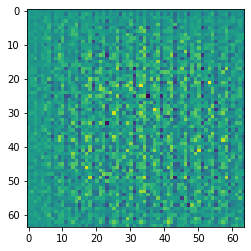

In [13]:
generator = make_generator_model()

noise = tf.random.normal([1, noise_dim])

generated_image = generator(noise,training=False)

plt.imshow(generated_image[0, :, :, 0])

In [14]:
print(generated_image.shape)
print(noise.shape)

(1, 64, 64, 3)
(1, 128)


### The Discriminator

The discriminator is a CNN-based image classifer.

In [15]:
def make_discriminator_model():
    model = tf.keras.Sequential()   
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[64, 64, 3]))   
    model.add(layers.LeakyReLU())
    #model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5,5), 
                             strides=(2,2),
                             padding='same'))
    model.add(layers.LeakyReLU())
    #model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(256, (5,5), 
                             strides=(2,2),
                             padding='same'))
    model.add(layers.LeakyReLU())
    #model.add(layers.Dropout(0.3))

        
    model.add(layers.Conv2D(512, (5,5), 
                             strides=(2,2),
                             padding='same'))
    model.add(layers.LeakyReLU())
    #model.add(layers.Dropout(0.3))
    
    
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    
    print("DISCRIMINATOR")
    model.summary()
    
    return model
    

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [16]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

DISCRIMINATOR
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        4864      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       204928    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 256)         819456    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4

## Define the loss and optimizers

Define loss function and optimizers for both models.

In [17]:
# This method returns a helper funciton to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

In [18]:
# Label smoothing -- technique from GAN hacks, instead of assigning 1/0 as class labels, we assign a random integer in range [0.7, 1.0] for positive class
# and [0.0, 0.3] for negative class

def smooth_positive_labels(y):
    return y - 0.3 + (np.random.random(y.shape) * 0.5)

def smooth_negative_labels(y):
    return y + np.random.random(y.shape) * 0.3

In [19]:
# randomly flip some labels
def noisy_labels(y, p_flip):
    # determine the number of labels to flip
    n_select = int(p_flip * int(y.shape[0]))
    # choose labels to flip
    flip_ix = np.random.choice([i for i in range(int(y.shape[0]))], size=n_select)
    
    op_list = []
    # invert the labels in place
    #y_np[flip_ix] = 1 - y_np[flip_ix]
    for i in range(int(y.shape[0])):
        if i in flip_ix:
            op_list.append(tf.subtract(1., y[i]))
        else:
            op_list.append(y[i])
    
    outputs = tf.stack(op_list)
    return outputs

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake(generated) images to an array of 0s.

In [20]:
def discriminator_loss(real_output, fake_output):
    real_output_noise = noisy_labels(tf.ones_like(real_output), 0.05)
    fake_output_noise = noisy_labels(tf.zeros_like(fake_output), 0.05)
    real_output_smooth = smooth_positive_labels(real_output_noise)
    fake_output_smooth = smooth_negative_labels(fake_output_noise)
 
    real_loss = cross_entropy(tf.ones_like(real_output_smooth), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output_smooth), fake_output)
    
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss

The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, we will compare the discriminators decisions on the generated images to an array of 1s.

In [21]:
def generator_loss(fake_output):
    fake_output_smooth = smooth_negative_labels(tf.ones_like(fake_output))
    return cross_entropy(tf.ones_like(fake_output_smooth), fake_output)

The discriminator and the generator optimizers are different since we will train two networks separately.

In [22]:
generator_optimizer = tf.optimizers.Adam(learning_rate=lr_initial_g, beta_1=0.5)
discriminator_optimizer = tf.optimizers.Adam(learning_rate=lr_initial_d, beta_1=0.5)

### Save checkpoints

In [23]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop

In [24]:
EPOCHS = 280
num_examples_to_generate = 64

# we will reuse this seed overtime (so it's easier)
# to visualize progress in the animated
seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [25]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

### Generate and save images

In [26]:
def train(dataset, epochs):
    for epoch in tqdm_notebook(range(epochs)):
        start = time.time()
        new_lr_d = lr_initial_d
        new_lr_g = lr_initial_g  
        global_step = 0
        
        for image_batch in dataset:
            train_step(image_batch)
            
        # Produce images for the GIF as we go
        #display.clear_output(wait=True)
        generate_and_save_images(generator,
                             epoch + 1,
                             seed)
        
        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
            
        # Cosine learning rate decay
        if (epoch + 1) % decay_step == 0:
            new_lr_d = tf.compat.v1.train.cosine_decay(new_lr_d, min(global_step, lr_decay_steps), lr_decay_steps)
            new_lr_g = tf.compat.v1.train.cosine_decay(new_lr_g, min(global_step, lr_decay_steps), lr_decay_steps)
            generator_optimizer = tf.optimizers.Adam(learning_rate=new_lr_d, beta_1=0.5)
            discriminator_optimizer = tf.optimizers.Adam(learning_rate=new_lr_g, beta_1=0.5)   

        #print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        
    # Generate after the final epoch     
    #display.clear_output(wait=True)
    generate_and_save_images(generator,
                           epochs,
                           seed)   
    

In [27]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)
    
    fig = plt.figure(figsize=(14,14))
    for i in range(predictions.shape[0]):
        plt.subplot(8, 8, i + 1)
        plt.imshow((predictions[i, :, :, :] + 1.)/2.)
        plt.axis('off')
    plt.savefig('dcgan/image_at_epoch_{}.png'.format(epoch))
    plt.close(fig)
    #plt.show()
    

### Train the model

In [28]:
%%time
train(train_dataset, EPOCHS)

/home/mattmann/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



CPU times: user 49min 50s, sys: 6min 41s, total: 56min 31s
Wall time: 2h 8min 46s


In [29]:
anim_file = 'dcgan/dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('dcgan/image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)


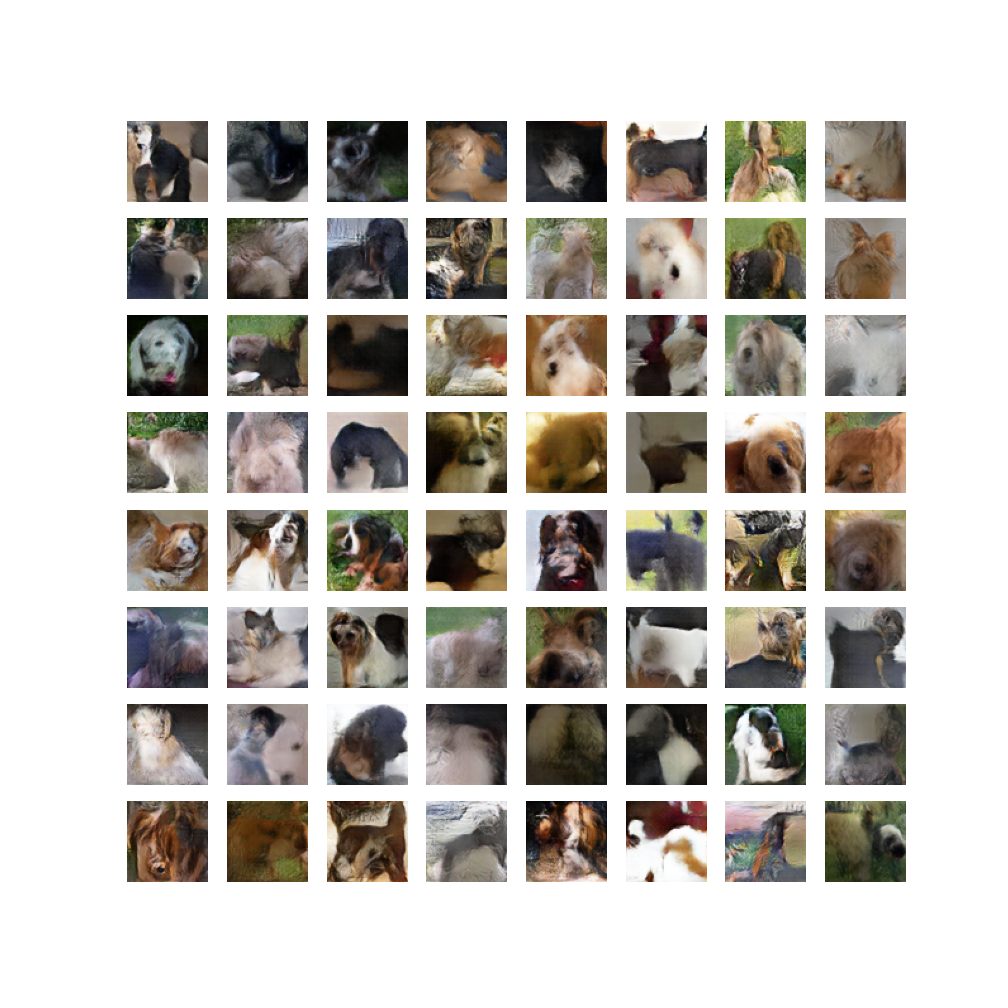

In [30]:
embed.embed_file('dcgan/image_at_epoch_'+str(EPOCHS)+'.png')

## Submit to Kaggle

In [31]:
from keras.preprocessing import image

In [32]:
%%time
if not os.path.exists('./output_images'):
    os.mkdir('./output_images')
i_batch_size = 50
n_images = 10000
for i_batch in tqdm_notebook(range(0, n_images, i_batch_size)):
    noise = np.random.uniform(-1.0, 1.0, [i_batch_size, noise_dim]).astype(np.float32)
    gen_images = generator(noise, training=False)
    gen_images = gen_images * 127.5 + 127.5
    for j in range(i_batch_size):
        img = image.array_to_img(gen_images[j])
        imsave(os.path.join('./output_images',f'sample_{i_batch + j + 1}.png'), img)
        if i_batch + j + 1 == n_images:
            break
print(len(os.listdir('./output_images')))

/home/mattmann/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """



10000
CPU times: user 14.8 s, sys: 0 ns, total: 14.8 s
Wall time: 14.1 s


In [33]:
if os.path.exists('images.zip'):
    os.remove('images.zip')
shutil.make_archive('images', 'zip', './output_images')

'/home/mattmann/git/DCGAN-Dog-Generator/images.zip'

In [34]:
def generate_test_image(model, noise_dim=noise_dim):
    test_input = tf.random.normal([1, noise_dim])
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(5,5))
    plt.imshow((predictions[0, :, :, :] * 127.5 + 127.5) / 255.)
    plt.axis('off') 
    plt.show()

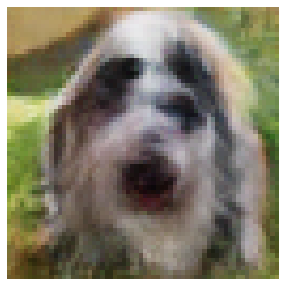

In [38]:
generate_test_image(generator)